In [1]:
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


In [2]:
import os
import pymatgen
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import trange, tqdm

In [3]:
structures = pd.read_csv("datasets/dichalcogenides_innopolis_202105/defects.csv", index_col=0)

In [4]:
defects_descriptors = pd.read_csv("datasets/dichalcogenides_innopolis_202105/descriptors.csv", index_col=0)

In [5]:
import pymatgen.io.cif
STRUCTURES_FOLDER = "datasets/dichalcogenides_innopolis_202105/initial/"
initial_structures = dict()
for structure_file in tqdm(os.listdir(STRUCTURES_FOLDER)):
  this_file = pymatgen.io.cif.CifParser(os.path.join(STRUCTURES_FOLDER, structure_file))
  initial_structures[os.path.splitext(structure_file)[0]] = this_file.get_structures()[0]

  0%|          | 0/3480 [00:00<?, ?it/s]

/temporary/pymatgen/pymatgen/io/cif.py:1123: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



In [6]:
structures["initial_structure"] = structures.apply(lambda row: initial_structures[row._id], axis=1)

In [7]:
import matplotlib
import pylab

from math import floor, ceil
from random import shuffle, seed
from megnet.models import MEGNetModel
from megnet.data.graph import GaussianDistance
from megnet.data.crystal import CrystalGraph
from megnet.data.molecule import MolecularGraph
from megnet.utils.preprocessing import StandardScaler
from megnet.callbacks import ModelCheckpointMAE
from pymatgen.core import Lattice, Structure, Molecule

cm = pylab.get_cmap('Set1')

import tensorflow as tf
import numpy as np

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train, test = train_test_split(structures, test_size=0.25, random_state=42)

In [10]:
# Must all be intensive
# target: (checkpoint, intensive)
checkpoints = {
  "energy_per_atom": ("callback/val_mae_00018_0.036552.hdf5", True),
  "homo": ("callback/val_mae_00010_0.072305.hdf5", True),
  "energy": ("callback/val_mae_00022_3.502786.hdf5", False)
}

In [11]:
# TODO(kazeevn) save scaler
gc = CrystalGraph(bond_converter=GaussianDistance(np.linspace(0, 5, 100), 0.5), cutoff=6)
for target, description in checkpoints.items():
  scaler = StandardScaler.from_training_data(train["initial_structure"],
                                             train[target], is_intensive=description[1])
  model = MEGNetModel(nfeat_edge=100, nfeat_global=2, graph_converter=gc)
  model.load_weights(description[0])
  model.target_scaler = scaler
  test.loc[:, f"predicted_{target}"] = model.predict_structures(test["initial_structure"].values)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



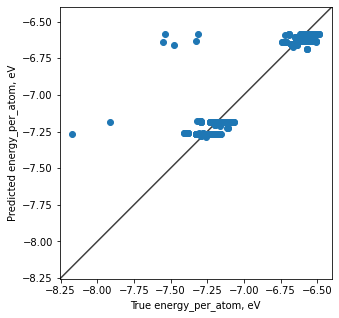

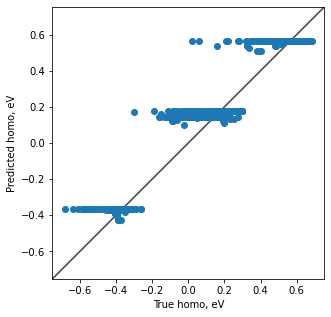

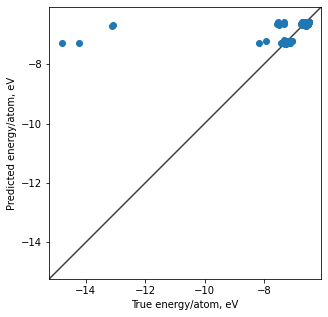

In [12]:
for target, description in checkpoints.items():
  fig, ax = plt.subplots(figsize=(8, 5))
  if description[1]:
    ax.scatter(test[target], test.loc[:, f"predicted_{target}"])
    ax.set_xlabel(f"True {target}, eV")
    ax.set_ylabel(f"Predicted {target}, eV")
  else:
    n_atoms = test.initial_structure.apply(len)
    ax.scatter(test[target]/n_atoms, test.loc[:, f"predicted_{target}"]/n_atoms)
    ax.set_xlabel(f"True {target}/atom, eV")
    ax.set_ylabel(f"Predicted {target}/atom, eV")
  lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

  # now plot both limits against eachother
  ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
  ax.set_aspect('equal')
  ax.set_xlim(lims)
  ax.set_ylim(lims);

In [13]:
averaged = test.groupby("descriptor_id").mean()

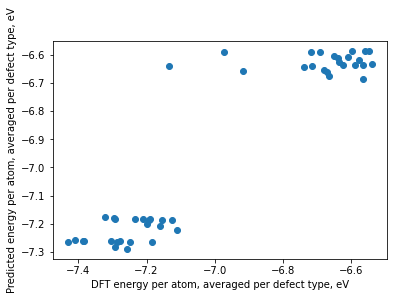

In [19]:
fig, ax = plt.subplots()
ax.scatter(averaged.energy_per_atom, averaged.predicted_energy_per_atom)
ax.set_xlabel("DFT energy per atom, averaged per defect type, eV")
ax.set_ylabel("Predicted energy per atom, averaged per defect type, eV");

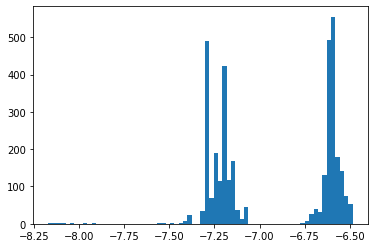

In [15]:
plt.hist(structures.energy_per_atom, bins=70);

In [16]:
import ase.io
def get_gpaw_energies(defect_db_path:str):
    energies = []
    for file_ in os.listdir(defect_db_path):
        if not file_.startswith("id"):
            continue
        this_folder = os.path.join(defect_db_path, file_, "relaxed", "trajectory")
        for traj_file in os.listdir(this_folder):
            try:
              this_structure = ase.io.read(os.path.join(this_folder, traj_file), index="-1")
              energies.append(this_structure.get_potential_energy()/len(this_structure))
            except ase.io.formats.UnknownFileTypeError:
                pass
    return energies

old_dataset = get_gpaw_energies("./datasets/raw_ruslan_202104/new_datasets/defectDB/")

-8.17101564483752


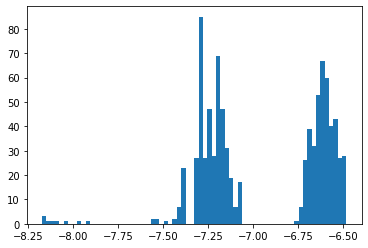

In [20]:
plt.hist(old_dataset, bins=70)
print(min(old_dataset))

In [44]:
import pymatgen.io.ase

In [52]:
from ase.visualize import view
view(pymatgen.io.ase.AseAtomsAdaptor.get_atoms(
  structures.iloc[1500].initial_structure), viewer='x3d', repeat=(2,2,1))